In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import MattingUNet3, MattingUNetTrainerDistr, get_all_files, MattingDataset
from matplotlib import pyplot as plt
from torch import nn
import torch
from pathlib import Path

In [3]:
PREPARED_FOLDER = Path("/media/rustam/data/matting")
train_test_files = get_all_files(PREPARED_FOLDER, 11)
print(len(train_test_files))

2485


In [5]:
from sklearn.model_selection import train_test_split
train_files, test_files = train_test_split(train_test_files,  test_size=0.2, shuffle=True)

In [6]:
print(len(test_files), len(train_files))
print(test_files[0])

497 1988
(PosixPath('/media/rustam/data/matting/0150-b+'), '00242')


In [7]:
a = MattingDataset(test_files, max_files=5, th=0.1)
for data in a:
    matting, seg, image, feats, aoi = data
    print(aoi.shape)

torch.Size([1, 432, 768])
torch.Size([1, 432, 768])
torch.Size([1, 432, 768])
torch.Size([1, 432, 768])
torch.Size([1, 432, 768])


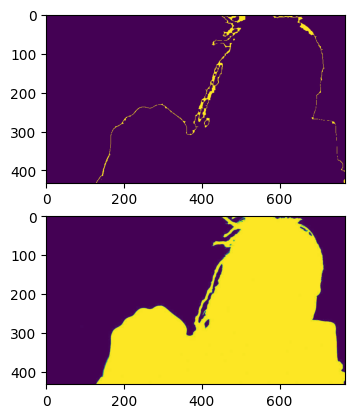

In [8]:
fig, ax = plt.subplots(2,1)
ax[0].imshow(aoi.permute(1,2,0).cpu().numpy())
ax[1].imshow(matting.permute(1,2,0).cpu().numpy())

In [9]:
from torchvision import transforms as tf


REFERENCE_FRAME = 0
NUM_POINTS = 4

IMAGE_SIZE = (200, 320)

BATCH_SIZE = 20

transform_train = tf.Compose([
    tf.Resize(IMAGE_SIZE),
    # tf.RandomPerspective(),
    tf.ElasticTransform(),
    tf.RandomVerticalFlip(),
    tf.RandomHorizontalFlip(),
])
transform_test = tf.Compose( [ tf.Resize(IMAGE_SIZE) ])

model = torch.nn.DataParallel(MattingUNet3(use_sigmoid=True))
# model = MattingUNet3(use_sigmoid=True).to("cuda:0")
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
l1_loss = nn.L1Loss(reduction='sum')

In [48]:
NAME = 'test10'
checkpoint = '0109'
MAX_FILES = 2000
SAVE_EVERY = 24

In [49]:
trainer = MattingUNetTrainerDistr(
    model=model,
    optimizer=optimizer,
    name=NAME,
    load=checkpoint,
    loss_fn=l1_loss,
    save_every=SAVE_EVERY,
    test_files=test_files,
    train_files=train_files,
    batch_size=BATCH_SIZE,
    transforms_test=transform_test,
    transforms_train=transform_train,
    max_files=MAX_FILES,
    device=torch.device("cuda:0"),
    lr=None,
)

In [ ]:
trainer.train(10)


In [ ]:

plt.plot(trainer.test_losses[10:], label="test")
plt.plot(trainer.train_losses[10:], label="train")
plt.legend()

In [ ]:
trainer.mul_lr(0.3)
trainer.get_lr()


In [ ]:

# print(vision_feats.device)
matt, pred = trainer.matting("/media/rustam/data/matting/0006-b+", "00025")


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(matt)
ax[1].imshow(pred)


In [11]:
trainer.mul_lr(0.3)
# trainer.set_lr(1e-1)

In [ ]:
trainer.get_lr()

In [ ]:
list(enumerate(trainer.test_losses))

In [ ]:
for q in model.named_parameters():
    if len(q[1]) == 0:
        continue
    min = q[1].min().item()
    max = q[1].max().item()

    print(f"{'!' if min == max else ''}{q[0]}: {tuple(q[1].shape)} {min:0.4f} - {max:0.4f}")